# ch11 신경망과 케라스 
### 01. 텐스플로우 2.0 이상 

In [ ]:
import tensorflow as tf
print(tf.__version__)

In [ ]:
import numpy as np
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

### 02. 퍼셉트론 

- 사이킷런 Pereceptron()과 `max_iter` 와  `tol` 의미 

In [ ]:
import numpy as np
from sklearn.datasets import load_iris
from sklearn.linear_model import Perceptron

iris = load_iris()
X = iris.data[:, (2, 3)]  # petal length, petal width
y = (iris.target == 0).astype(np.int)

per_clf = Perceptron(max_iter=1000, tol=1e-3, random_state=42)
per_clf.fit(X, y)

y_pred = per_clf.predict([[2, 0.5]])

In [ ]:
y_pred

In [ ]:
a = -per_clf.coef_[0][0] / per_clf.coef_[0][1]
b = -per_clf.intercept_ / per_clf.coef_[0][1]

In [ ]:
per_clf.coef_

In [ ]:
per_clf.intercept_

In [ ]:
axes = [0, 5, 0, 3]

x0, x1 = np.meshgrid(
        np.linspace(axes[0], axes[1], 500).reshape(-1, 1),
        np.linspace(axes[2], axes[3], 200).reshape(-1, 1),
    )
X_new = np.c_[x0.ravel(), x1.ravel()]
y_predict = per_clf.predict(X_new)
zz = y_predict.reshape(x0.shape)

In [ ]:
plt.figure(figsize=(10, 4))
plt.plot(X[y==0, 0], X[y==0, 1], "bs", label="Not Iris-Setosa")
plt.plot(X[y==1, 0], X[y==1, 1], "yo", label="Iris-Setosa")

plt.plot([axes[0], axes[1]], [a * axes[0] + b, a * axes[1] + b], "k-", linewidth=3)
from matplotlib.colors import ListedColormap
custom_cmap = ListedColormap(['#9898ff', '#fafab0'])

plt.contourf(x0, x1, zz, cmap=custom_cmap)
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.legend(loc="lower right", fontsize=14)
plt.axis(axes)

plt.show()

### 03. Activation functions

In [ ]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def relu(z):
    return np.maximum(0, z)

def derivative(f, z, eps=0.000001):
    return (f(z + eps) - f(z - eps))/(2 * eps)

In [ ]:
z = np.linspace(-5, 5, 200)

plt.figure(figsize=(11,4))

plt.subplot(121)
plt.plot(z, np.sign(z), "r-", linewidth=1, label="Step")
plt.plot(z, sigmoid(z), "g--", linewidth=2, label="Sigmoid")
plt.plot(z, np.tanh(z), "b-", linewidth=2, label="Tanh")
plt.plot(z, relu(z), "m-.", linewidth=2, label="ReLU")
plt.grid(True)
plt.legend(loc="center right", fontsize=14)
plt.title("Activation functions", fontsize=14)
plt.axis([-5, 5, -1.2, 1.2])

plt.subplot(122)
plt.plot(z, derivative(np.sign, z), "r-", linewidth=1, label="Step")
plt.plot(0, 0, "ro", markersize=5)
plt.plot(0, 0, "rx", markersize=10)
plt.plot(z, derivative(sigmoid, z), "g--", linewidth=2, label="Sigmoid")
plt.plot(z, derivative(np.tanh, z), "b-", linewidth=2, label="Tanh")
plt.plot(z, derivative(relu, z), "m-.", linewidth=2, label="ReLU")
plt.grid(True)
#plt.legend(loc="center right", fontsize=14)
plt.title("Derivatives", fontsize=14)
plt.axis([-5, 5, -0.2, 1.2])

plt.show()

In [ ]:
def heaviside(z):
    return (z >= 0).astype(z.dtype)

def mlp_xor(x1, x2, activation=heaviside):
    return activation(-activation(x1 + x2 - 1.5) + activation(x1 + x2 - 0.5) - 0.5)

In [ ]:
x1s = np.linspace(-0.2, 1.2, 100)
x2s = np.linspace(-0.2, 1.2, 100)
x1, x2 = np.meshgrid(x1s, x2s)

z1 = mlp_xor(x1, x2, activation=heaviside)
z2 = mlp_xor(x1, x2, activation=sigmoid)

plt.figure(figsize=(10,4))

plt.subplot(121)
plt.contourf(x1, x2, z1)
plt.plot([0, 1], [0, 1], "gs", markersize=20)
plt.plot([0, 1], [1, 0], "y^", markersize=20)
plt.title("Activation function: heaviside", fontsize=14)
plt.grid(True)

plt.subplot(122)
plt.contourf(x1, x2, z2)
plt.plot([0, 1], [0, 1], "gs", markersize=20)
plt.plot([0, 1], [1, 0], "y^", markersize=20)
plt.title("Activation function: sigmoid", fontsize=14)
plt.grid(True)

### 04. Building an Image Classifier

In [ ]:
import tensorflow as tf
from tensorflow import keras

In [ ]:
tf.__version__

In [ ]:
keras.__version__

In [ ]:
fashion_mnist = keras.datasets.fashion_mnist
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist.load_data()

- 패선 NMINST는 총 60,000개 훈련 데이터, 픽셀 크기는 28x28
- 테스트 데이터 개수는 10,000개 

In [ ]:
X_train_full.shape

In [ ]:
X_test.shape

In [ ]:
X_train_full.dtype

- 검증 데이터 5000개 사용 
- 훈련은 55,000개 모두 0~1로 스케일

In [ ]:
X_valid, X_train = X_train_full[:5000] / 255., X_train_full[5000:] / 255.
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]
X_test = X_test / 255.

In [ ]:
plt.imshow(X_train[0], cmap="binary")
plt.axis('off')
plt.show()

In [ ]:
plt.imshow(X_train[2], cmap="binary")
plt.axis('off')
plt.show()

In [ ]:
y_train

In [ ]:
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
               "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

So the first image in the training set is a coat:

In [ ]:
class_names[y_train[0]]

In [ ]:
X_valid.shape

In [ ]:
X_test.shape

Let's take a look at a sample of the images in the dataset:

In [ ]:
n_rows = 4; n_cols = 10
plt.figure(figsize=(n_cols * 1.2, n_rows * 1.2))
for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(X_train[index], cmap="binary", interpolation="nearest")
        plt.axis('off')
        plt.title(class_names[y_train[index]], fontsize=12)
plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()

# 05. 케라스 사용하기

In [ ]:

model = keras.models.Sequential()

model.add(keras.layers.Flatten(input_shape=[28, 28]))

model.add(keras.layers.Dense(300, activation="relu"))

model.add(keras.layers.Dense(100, activation="relu"))

model.add(keras.layers.Dense(10, activation="softmax"))


In [ ]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="relu"),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(10, activation="softmax")
])

In [ ]:
model.layers

In [ ]:
model.summary()

In [ ]:
keras.utils.plot_model(model, "my_mnist_model.png", show_shapes=True)

In [ ]:
hidden1 = model.layers[1]
hidden1.name

In [ ]:
model.get_layer(hidden1.name) is hidden1

In [ ]:
weights, biases = hidden1.get_weights()

In [ ]:
weights

In [ ]:
weights.shape

In [ ]:
biases

In [ ]:
biases.shape

In [ ]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer="sgd",
              metrics=["accuracy"])

This is equivalent to:

```python
model.compile(loss=keras.losses.sparse_categorical_crossentropy,
              optimizer=keras.optimizers.SGD(),
              metrics=[keras.metrics.sparse_categorical_accuracy])
```

In [ ]:
history = model.fit(X_train, y_train, epochs=30,
                    validation_data=(X_valid, y_valid))

In [ ]:
history.params

In [ ]:
print(history.epoch)

In [ ]:
history.history.keys()

In [ ]:
#!pip install pandas

In [ ]:
import pandas as pd
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

In [ ]:
model.evaluate(X_test, y_test)

In [ ]:
X_new = X_test[:3]
y_proba = model.predict(X_new)
y_proba.round(2)

In [ ]:
y_pred = model.predict_classes(X_new);y_pred

In [ ]:
np.array(class_names)[y_pred]

In [ ]:
y_new = y_test[:3];y_new

In [ ]:
plt.figure(figsize=(7.2, 2.4))
for index, image in enumerate(X_new):
    plt.subplot(1, 3, index + 1)
    plt.imshow(image, cmap="binary", interpolation="nearest")
    plt.axis('off')
    plt.title(class_names[y_test[index]], fontsize=12)
plt.subplots_adjust(wspace=0.2, hspace=0.5)

plt.show()

### 06. 다중퍼셉트론 회귀 MLP

- California housing dataset 

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

In [2]:
import pandas as pd

In [3]:
keras.__version__

'2.2.4-tf'

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
np.random.seed(42)
tf.random.set_seed(42)

In [6]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

housing = fetch_california_housing()

X_train_full, X_test, y_train_full, y_test = train_test_split(housing.data, 
    housing.target, random_state=42)

X_train, X_valid, y_train, y_valid = train_test_split(
    X_train_full, y_train_full, random_state=42)

scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_valid = scaler.transform(X_valid)
X_test = scaler.transform(X_test)

In [7]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="relu", 
                       input_shape=X_train.shape[1:]),
    keras.layers.Dense(1)
])

In [ ]:
model.compile(loss="mean_squared_error", 
    optimizer=keras.optimizers.SGD(lr=1e-3))

In [9]:
history = model.fit(X_train, y_train, 
    epochs=30, validation_data=(X_valid, y_valid))

Train on 11610 samples, validate on 3870 samples
Epoch 1/30
11610/11610 [==============================] - 3s 263us/sample - loss: 1.6321 - val_loss: 1.5903
Epoch 2/30
11610/11610 [==============================] - 1s 77us/sample - loss: 0.7124 - val_loss: 0.6539
Epoch 3/30
11610/11610 [==============================] - 1s 75us/sample - loss: 0.6348 - val_loss: 0.6039
Epoch 4/30
11610/11610 [==============================] - 1s 81us/sample - loss: 0.5983 - val_loss: 0.5738
Epoch 5/30
11610/11610 [==============================] - 1s 83us/sample - loss: 0.5713 - val_loss: 0.5406
Epoch 6/30
11610/11610 [==============================] - 1s 80us/sample - loss: 0.5482 - val_loss: 0.5221
Epoch 7/30
11610/11610 [==============================] - 1s 82us/sample - loss: 0.5298 - val_loss: 0.4965
Epoch 8/30
11610/11610 [==============================] - 1s 91us/sample - loss: 0.5138 - val_loss: 0.4843
Epoch 9/30
11610/11610 [==============================] - 1s 85us/sample - loss: 0.5005 - val_

In [10]:
mse_test = model.evaluate(X_test, y_test)

5160/1 [================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

In [11]:
X_new = X_test[:3]

y_pred = model.predict(X_new)

In [ ]:
import matplotlib as mpl
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

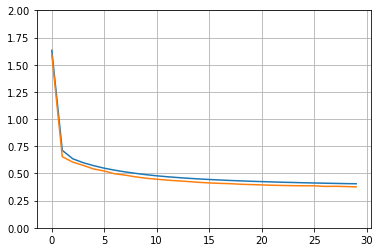

In [13]:
plt.plot(pd.DataFrame(history.history))
plt.grid(True)
plt.gca().set_ylim(0, 2)
plt.show()

In [14]:
y_pred

array([[0.39039648],
       [1.7924039 ],
       [3.2830522 ]], dtype=float32)

# Functional API

Not all neural network models are simply sequential. Some may have complex topologies. Some may have multiple inputs and/or multiple outputs. For example, a Wide & Deep neural network (see [paper](https://ai.google/research/pubs/pub45413)) connects all or part of the inputs directly to the output layer.

In [15]:
np.random.seed(42)
tf.random.set_seed(42)

In [16]:
input_ = keras.layers.Input(shape=X_train.shape[1:])

hidden1 = keras.layers.Dense(30, activation="relu")(input_)

hidden2 = keras.layers.Dense(30, activation="relu")(hidden1)

concat = keras.layers.concatenate([input_, hidden2])

output = keras.layers.Dense(1)(concat)

model = keras.models.Model(inputs=[input_], outputs=[output])

In [17]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 8)]          0                                            
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 30)           270         input_1[0][0]                    
__________________________________________________________________________________________________
dense_3 (Dense)                 (None, 30)           930         dense_2[0][0]                    
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 38)           0           input_1[0][0]                    
                                                                 dense_3[0][0]                

In [18]:
model.compile(loss="mean_squared_error", optimizer=keras.optimizers.SGD(lr=1e-3))

history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))

Train on 11610 samples, validate on 3870 samples
Epoch 1/20
11610/11610 [==============================] - 2s 169us/sample - loss: 1.2474 - val_loss: 0.8727
Epoch 2/20
11610/11610 [==============================] - 1s 87us/sample - loss: 0.6341 - val_loss: 0.8881
Epoch 3/20
11610/11610 [==============================] - 1s 93us/sample - loss: 0.5885 - val_loss: 0.5573
Epoch 4/20
11610/11610 [==============================] - 1s 96us/sample - loss: 0.5599 - val_loss: 0.5238
Epoch 5/20
11610/11610 [==============================] - 1s 94us/sample - loss: 0.5367 - val_loss: 0.6201
Epoch 6/20
11610/11610 [==============================] - 1s 95us/sample - loss: 0.5170 - val_loss: 0.4979
Epoch 7/20
11610/11610 [==============================] - 1s 104us/sample - loss: 0.5022 - val_loss: 0.5240
Epoch 8/20
11610/11610 [==============================] - 1s 112us/sample - loss: 0.4885 - val_loss: 0.4538
Epoch 9/20
11610/11610 [==============================] - 1s 113us/sample - loss: 0.4778 - v

In [19]:
mse_test = model.evaluate(X_test, y_test)
y_pred = model.predict(X_new)

5160/1 [================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

What if you want to send different subsets of input features through the wide or deep paths? We will send 5 features (features 0 to 4), and 6 through the deep path (features 2 to 7). Note that 3 features will go through both (features 2, 3 and 4).

In [20]:
np.random.seed(42)
tf.random.set_seed(42)

In [21]:
input_A = keras.layers.Input(shape=[5], name="wide_input")
input_B = keras.layers.Input(shape=[6], name="deep_input")
hidden1 = keras.layers.Dense(30, activation="relu")(input_B)
hidden2 = keras.layers.Dense(30, activation="relu")(hidden1)
concat = keras.layers.concatenate([input_A, hidden2])
output = keras.layers.Dense(1, name="output")(concat)
model = keras.models.Model(inputs=[input_A, input_B], outputs=[output])

In [22]:
model.compile(loss="mse", optimizer=keras.optimizers.SGD(lr=1e-3))

X_train_A, X_train_B = X_train[:, :5], X_train[:, 2:]
X_valid_A, X_valid_B = X_valid[:, :5], X_valid[:, 2:]
X_test_A, X_test_B = X_test[:, :5], X_test[:, 2:]
X_new_A, X_new_B = X_test_A[:3], X_test_B[:3]

history = model.fit((X_train_A, X_train_B), y_train, epochs=20,
                    validation_data=((X_valid_A, X_valid_B), y_valid))
mse_test = model.evaluate((X_test_A, X_test_B), y_test)
y_pred = model.predict((X_new_A, X_new_B))

Train on 11610 samples, validate on 3870 samples
Epoch 1/20
11610/11610 [==============================] - 2s 204us/sample - loss: 1.8095 - val_loss: 1.4409
Epoch 2/20
11610/11610 [==============================] - 1s 108us/sample - loss: 0.6798 - val_loss: 0.6123
Epoch 3/20
11610/11610 [==============================] - 1s 97us/sample - loss: 0.5957 - val_loss: 0.5618
Epoch 4/20
11610/11610 [==============================] - 1s 97us/sample - loss: 0.5580 - val_loss: 0.5514
Epoch 5/20
11610/11610 [==============================] - 1s 98us/sample - loss: 0.5331 - val_loss: 0.5073
Epoch 6/20
11610/11610 [==============================] - 1s 99us/sample - loss: 0.5124 - val_loss: 0.4860
Epoch 7/20
11610/11610 [==============================] - 1s 100us/sample - loss: 0.4972 - val_loss: 0.4631
Epoch 8/20
11610/11610 [==============================] - 1s 99us/sample - loss: 0.4834 - val_loss: 0.4514
Epoch 9/20
11610/11610 [==============================] - 1s 100us/sample - loss: 0.4746 - v

Adding an auxiliary output for regularization:

In [23]:
np.random.seed(42)
tf.random.set_seed(42)

In [24]:
input_A = keras.layers.Input(shape=[5], name="wide_input")
input_B = keras.layers.Input(shape=[6], name="deep_input")
hidden1 = keras.layers.Dense(30, activation="relu")(input_B)
hidden2 = keras.layers.Dense(30, activation="relu")(hidden1)
concat = keras.layers.concatenate([input_A, hidden2])
output = keras.layers.Dense(1, name="main_output")(concat)
aux_output = keras.layers.Dense(1, name="aux_output")(hidden2)
model = keras.models.Model(inputs=[input_A, input_B],
                           outputs=[output, aux_output])

In [25]:
model.compile(loss=["mse", "mse"], loss_weights=[0.9, 0.1], optimizer=keras.optimizers.SGD(lr=1e-3))

In [26]:
history = model.fit([X_train_A, X_train_B], [y_train, y_train], epochs=20,
                    validation_data=([X_valid_A, X_valid_B], [y_valid, y_valid]))

Train on 11610 samples, validate on 3870 samples
Epoch 1/20
11610/11610 [==============================] - 3s 269us/sample - loss: 2.1329 - main_output_loss: 1.9166 - aux_output_loss: 4.0719 - val_loss: 2.2885 - val_main_output_loss: 1.5657 - val_aux_output_loss: 8.7861
Epoch 2/20
11610/11610 [==============================] - 1s 117us/sample - loss: 0.8910 - main_output_loss: 0.6989 - aux_output_loss: 2.6202 - val_loss: 1.4258 - val_main_output_loss: 0.6285 - val_aux_output_loss: 8.5972
Epoch 3/20
11610/11610 [==============================] - 1s 123us/sample - loss: 0.7397 - main_output_loss: 0.6064 - aux_output_loss: 1.9374 - val_loss: 1.3894 - val_main_output_loss: 0.5941 - val_aux_output_loss: 8.5417
Epoch 4/20
11610/11610 [==============================] - 1s 117us/sample - loss: 0.6746 - main_output_loss: 0.5684 - aux_output_loss: 1.6301 - val_loss: 1.3275 - val_main_output_loss: 0.6028 - val_aux_output_loss: 7.8451
Epoch 5/20
11610/11610 [==============================] - 2s 14

In [27]:
total_loss, main_loss, aux_loss = model.evaluate(
    [X_test_A, X_test_B], [y_test, y_test])
y_pred_main, y_pred_aux = model.predict([X_new_A, X_new_B])

5160/1 [================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

# The subclassing API

In [28]:
class WideAndDeepModel(keras.models.Model):
    def __init__(self, units=30, activation="relu", **kwargs):
        super().__init__(**kwargs)
        self.hidden1 = keras.layers.Dense(units, activation=activation)
        self.hidden2 = keras.layers.Dense(units, activation=activation)
        self.main_output = keras.layers.Dense(1)
        self.aux_output = keras.layers.Dense(1)
        
    def call(self, inputs):
        input_A, input_B = inputs
        hidden1 = self.hidden1(input_B)
        hidden2 = self.hidden2(hidden1)
        concat = keras.layers.concatenate([input_A, hidden2])
        main_output = self.main_output(concat)
        aux_output = self.aux_output(hidden2)
        return main_output, aux_output

model = WideAndDeepModel(30, activation="relu")

In [29]:
model.compile(loss="mse", loss_weights=[0.9, 0.1], optimizer=keras.optimizers.SGD(lr=1e-3))
history = model.fit((X_train_A, X_train_B), (y_train, y_train), epochs=10,
                    validation_data=((X_valid_A, X_valid_B), (y_valid, y_valid)))
total_loss, main_loss, aux_loss = model.evaluate((X_test_A, X_test_B), (y_test, y_test))
y_pred_main, y_pred_aux = model.predict((X_new_A, X_new_B))

Train on 11610 samples, validate on 3870 samples
Epoch 1/10
11610/11610 [==============================] - 3s 251us/sample - loss: 2.2968 - output_1_loss: 2.1826 - output_2_loss: 3.3166 - val_loss: 3.0093 - val_output_1_loss: 1.5519 - val_output_2_loss: 16.1139
Epoch 2/10
11610/11610 [==============================] - 1s 108us/sample - loss: 0.9760 - output_1_loss: 0.8529 - output_2_loss: 2.0834 - val_loss: 1.9291 - val_output_1_loss: 0.7524 - val_output_2_loss: 12.5119
Epoch 3/10
11610/11610 [==============================] - 1s 110us/sample - loss: 0.8288 - output_1_loss: 0.7270 - output_2_loss: 1.7431 - val_loss: 1.6768 - val_output_1_loss: 0.7256 - val_output_2_loss: 10.2305
Epoch 4/10
11610/11610 [==============================] - 1s 108us/sample - loss: 0.7637 - output_1_loss: 0.6744 - output_2_loss: 1.5665 - val_loss: 1.4544 - val_output_1_loss: 0.6860 - val_output_2_loss: 8.3638
Epoch 5/10
11610/11610 [==============================] - 1s 118us/sample - loss: 0.7227 - output_1_

In [30]:
model = WideAndDeepModel(30, activation="relu")

# Saving and Restoring

In [31]:
np.random.seed(42)
tf.random.set_seed(42)

In [32]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="relu", input_shape=[8]),
    keras.layers.Dense(30, activation="relu"),
    keras.layers.Dense(1)
])    

In [71]:
model.compile(loss="mse", optimizer=keras.optimizers.SGD(lr=1e-3))
history = model.fit(X_train, y_train, 
            epochs=10, validation_data=(X_valid, y_valid))
mse_test = model.evaluate(X_test, y_test)

Train on 11610 samples, validate on 3870 samples
Epoch 1/10
11610/11610 [==============================] - 3s 285us/sample - loss: 0.2769 - val_loss: 0.2770
Epoch 2/10
11610/11610 [==============================] - 2s 151us/sample - loss: 0.2732 - val_loss: 0.2756
Epoch 3/10
11610/11610 [==============================] - 2s 155us/sample - loss: 0.2720 - val_loss: 0.2754
Epoch 4/10
11610/11610 [==============================] - 1s 115us/sample - loss: 0.2713 - val_loss: 0.2747
Epoch 5/10
11610/11610 [==============================] - 2s 135us/sample - loss: 0.2710 - val_loss: 0.2745
Epoch 6/10
11610/11610 [==============================] - 1s 121us/sample - loss: 0.2707 - val_loss: 0.2743
Epoch 7/10
11610/11610 [==============================] - 1s 118us/sample - loss: 0.2704 - val_loss: 0.2743
Epoch 8/10
11610/11610 [==============================] - 2s 133us/sample - loss: 0.2703 - val_loss: 0.2745
Epoch 9/10
11610/11610 [==============================] - 2s 180us/sample - loss: 0.270

In [34]:
model.save("my_keras_model.h5")

In [35]:
model = keras.models.load_model("my_keras_model.h5")

In [36]:
model.predict(X_new)

array([[0.54909724],
       [1.6584849 ],
       [3.0271606 ]], dtype=float32)

In [37]:
model.save_weights("my_keras_weights.ckpt")

In [38]:
model.load_weights("my_keras_weights.ckpt")

### 08. 훈련중 콜백 사용하기

In [39]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [40]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="relu", input_shape=[8]),
    keras.layers.Dense(30, activation="relu"),
    keras.layers.Dense(1)
])    

In [41]:
model.compile(loss="mse", optimizer=keras.optimizers.SGD(lr=1e-3))

checkpoint_cb = keras.callbacks.ModelCheckpoint("my_keras_model.h5", 
                save_best_only=True)
history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid),
                    callbacks=[checkpoint_cb])

model = keras.models.load_model("my_keras_model.h5") 
# rollback to best model

mse_test = model.evaluate(X_test, y_test)

Train on 11610 samples, validate on 3870 samples
Epoch 1/10
11610/11610 [==============================] - 2s 168us/sample - loss: 1.8631 - val_loss: 3.2403
Epoch 2/10
11610/11610 [==============================] - 1s 83us/sample - loss: 0.6723 - val_loss: 0.6939
Epoch 3/10
11610/11610 [==============================] - 1s 85us/sample - loss: 0.5927 - val_loss: 0.5531
Epoch 4/10
11610/11610 [==============================] - 1s 86us/sample - loss: 0.5550 - val_loss: 0.5519
Epoch 5/10
11610/11610 [==============================] - 1s 82us/sample - loss: 0.5278 - val_loss: 0.5715
Epoch 6/10
11610/11610 [==============================] - 1s 81us/sample - loss: 0.5032 - val_loss: 0.5591
Epoch 7/10
11610/11610 [==============================] - 1s 93us/sample - loss: 0.4863 - val_loss: 0.4593
Epoch 8/10
11610/11610 [==============================] - 1s 90us/sample - loss: 0.4701 - val_loss: 0.4651
Epoch 9/10
11610/11610 [==============================] - 1s 96us/sample - loss: 0.4586 - val_

In [42]:
model.compile(loss="mse", optimizer=keras.optimizers.SGD(lr=1e-3))

early_stopping_cb = keras.callbacks.EarlyStopping(patience=10,
                    restore_best_weights=True)

history = model.fit(X_train, y_train, epochs=100,
                    validation_data=(X_valid, y_valid),
                    callbacks=[checkpoint_cb, early_stopping_cb)
                               
mse_test = model.evaluate(X_test, y_test)
                               

Train on 11610 samples, validate on 3870 samples
Epoch 1/100
11610/11610 [==============================] - 3s 219us/sample - loss: 0.4388 - val_loss: 0.4122
Epoch 2/100
11610/11610 [==============================] - 1s 85us/sample - loss: 0.4319 - val_loss: 0.4046
Epoch 3/100
11610/11610 [==============================] - 1s 85us/sample - loss: 0.4256 - val_loss: 0.4065
Epoch 4/100
11610/11610 [==============================] - 1s 86us/sample - loss: 0.4202 - val_loss: 0.3998
Epoch 5/100
11610/11610 [==============================] - 1s 86us/sample - loss: 0.4157 - val_loss: 0.3970
Epoch 6/100
11610/11610 [==============================] - 1s 87us/sample - loss: 0.4112 - val_loss: 0.3964
Epoch 7/100
11610/11610 [==============================] - 1s 88us/sample - loss: 0.4072 - val_loss: 0.3807
Epoch 8/100
11610/11610 [==============================] - 1s 86us/sample - loss: 0.4040 - val_loss: 0.3778
Epoch 9/100
11610/11610 [==============================] - 1s 85us/sample - loss: 0.40

In [43]:
class PrintValTrainRatioCallback(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        print("\nval/train: {:.2f}".format(logs["val_loss"] / logs["loss"]))

In [44]:
val_train_ratio_cb = PrintValTrainRatioCallback()
history = model.fit(X_train, y_train, epochs=1,
                    validation_data=(X_valid, y_valid),
                    callbacks=[val_train_ratio_cb])

Train on 11610 samples, validate on 3870 samples
11168/11610 [===========================>..] - ETA: 0s - loss: 0.3450
val/train: 1.10
11610/11610 [==============================] - 1s 95us/sample - loss: 0.3465 - val_loss: 0.3825


# TensorBoard

In [48]:
import os

In [49]:
root_logdir = os.path.join(os.curdir, "my_logs")

In [50]:
def get_run_logdir():
    import time
    run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
    return os.path.join(root_logdir, run_id)

run_logdir = get_run_logdir()
run_logdir

'.\\my_logs\\run_2020_01_29-22_48_32'

In [51]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [52]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="relu", input_shape=[8]),
    keras.layers.Dense(30, activation="relu"),
    keras.layers.Dense(1)
])    
model.compile(loss="mse", optimizer=keras.optimizers.SGD(lr=1e-3))

In [53]:
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)
history = model.fit(X_train, y_train, epochs=30,
                    validation_data=(X_valid, y_valid),
                    callbacks=[checkpoint_cb, tensorboard_cb])

Train on 11610 samples, validate on 3870 samples
Epoch 1/30
11610/11610 [==============================] - 2s 196us/sample - loss: 1.8631 - val_loss: 3.2403
Epoch 2/30
11610/11610 [==============================] - 1s 94us/sample - loss: 0.6723 - val_loss: 0.6939
Epoch 3/30
11610/11610 [==============================] - 1s 86us/sample - loss: 0.5927 - val_loss: 0.5531
Epoch 4/30
11610/11610 [==============================] - 1s 88us/sample - loss: 0.5550 - val_loss: 0.5519
Epoch 5/30
11610/11610 [==============================] - 1s 88us/sample - loss: 0.5278 - val_loss: 0.5715
Epoch 6/30
11610/11610 [==============================] - 1s 86us/sample - loss: 0.5032 - val_loss: 0.5591
Epoch 7/30
11610/11610 [==============================] - 1s 84us/sample - loss: 0.4863 - val_loss: 0.4593
Epoch 8/30
11610/11610 [==============================] - 1s 85us/sample - loss: 0.4701 - val_loss: 0.4651
Epoch 9/30
11610/11610 [==============================] - 1s 85us/sample - loss: 0.4586 - val_

To start the TensorBoard server, one option is to open a terminal, if needed activate the virtualenv where you installed TensorBoard, go to this notebook's directory, then type:

```bash
$ tensorboard --logdir=./my_logs --port=6006
```

You can then open your web browser to [localhost:6006](http://localhost:6006) and use TensorBoard. Once you are done, press Ctrl-C in the terminal window, this will shutdown the TensorBoard server.

Alternatively, you can load TensorBoard's Jupyter extension and run it like this:

In [54]:
%load_ext tensorboard
%tensorboard --logdir=./my_logs --port=6006

ERROR: Timed out waiting for TensorBoard to start. It may still be running as pid 20520.

In [55]:
run_logdir2 = get_run_logdir()
run_logdir2

'.\\my_logs\\run_2020_01_29-22_50_41'

In [56]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [57]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="relu", input_shape=[8]),
    keras.layers.Dense(30, activation="relu"),
    keras.layers.Dense(1)
])    
model.compile(loss="mse", optimizer=keras.optimizers.SGD(lr=0.05))

In [58]:
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir2)
history = model.fit(X_train, y_train, epochs=30,
                    validation_data=(X_valid, y_valid),
                    callbacks=[checkpoint_cb, tensorboard_cb])

Train on 11610 samples, validate on 3870 samples
Epoch 1/30
11610/11610 [==============================] - 2s 174us/sample - loss: 0.7860 - val_loss: 3.9608
Epoch 2/30
11610/11610 [==============================] - 1s 103us/sample - loss: 0.4406 - val_loss: 19.3300
Epoch 3/30
11610/11610 [==============================] - 1s 91us/sample - loss: 0.3807 - val_loss: 1.9256
Epoch 4/30
11610/11610 [==============================] - 1s 84us/sample - loss: 0.4055 - val_loss: 0.3552
Epoch 5/30
11610/11610 [==============================] - 1s 89us/sample - loss: 0.3706 - val_loss: 0.3235
Epoch 6/30
11610/11610 [==============================] - 1s 83us/sample - loss: 0.3641 - val_loss: 0.3160
Epoch 7/30
11610/11610 [==============================] - 1s 87us/sample - loss: 0.3504 - val_loss: 0.3156
Epoch 8/30
11610/11610 [==============================] - 1s 95us/sample - loss: 0.3393 - val_loss: 13.7286
Epoch 9/30
11610/11610 [==============================] - 1s 86us/sample - loss: 0.3783 - v

Notice how TensorBoard now sees two runs, and you can compare the learning curves.

Check out the other available logging options:

In [59]:
help(keras.callbacks.TensorBoard.__init__)

Help on function __init__ in module tensorflow.python.keras.callbacks:

__init__(self, log_dir='logs', histogram_freq=0, write_graph=True, write_images=False, update_freq='epoch', profile_batch=2, embeddings_freq=0, embeddings_metadata=None, **kwargs)
    Initialize self.  See help(type(self)) for accurate signature.



# Hyperparameter Tuning

In [60]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [72]:
def build_model(n_hidden=1, n_neurons=30, 
                learning_rate=3e-3, input_shape=[8]):
    
    model = keras.models.Sequential()
    model.add(keras.layers.InputLayer(input_shape=input_shape))
    
    for layer in range(n_hidden):
        model.add(keras.layers.Dense(n_neurons, activation="relu"))
        
    model.add(keras.layers.Dense(1))    
    optimizer = keras.optimizers.SGD(lr=learning_rate)
    model.compile(loss="mse", optimizer=optimizer)
    return model

In [62]:
keras_reg = keras.wrappers.scikit_learn.KerasRegressor(build_model)

In [63]:
keras_reg.fit(X_train, y_train, epochs=100,
              validation_data=(X_valid, y_valid),
              callbacks=[keras.callbacks.EarlyStopping(patience=10)])

Train on 11610 samples, validate on 3870 samples
Epoch 1/100
11610/11610 [==============================] - 2s 150us/sample - loss: 1.1815 - val_loss: 20.7837
Epoch 2/100
11610/11610 [==============================] - 1s 80us/sample - loss: 0.7013 - val_loss: 0.6646
Epoch 3/100
11610/11610 [==============================] - 1s 80us/sample - loss: 0.5197 - val_loss: 0.5974
Epoch 4/100
11610/11610 [==============================] - 1s 79us/sample - loss: 0.4811 - val_loss: 0.5292
Epoch 5/100
11610/11610 [==============================] - 1s 80us/sample - loss: 0.4565 - val_loss: 0.4813
Epoch 6/100
11610/11610 [==============================] - 1s 79us/sample - loss: 0.4393 - val_loss: 0.4501
Epoch 7/100
11610/11610 [==============================] - 1s 75us/sample - loss: 0.4283 - val_loss: 0.4231
Epoch 8/100
11610/11610 [==============================] - 1s 87us/sample - loss: 0.4205 - val_loss: 0.4072
Epoch 9/100
11610/11610 [==============================] - 1s 100us/sample - loss: 0.

In [64]:
mse_test = keras_reg.score(X_test, y_test)

5160/1 [================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

In [73]:
y_pred = keras_reg.predict(X_new)
y_pred

array([0.6270608, 1.7558155, 3.7607713], dtype=float32)

In [66]:
np.random.seed(42)
tf.random.set_seed(42)

In [80]:
from scipy.stats import reciprocal
from sklearn.model_selection import RandomizedSearchCV

param_distribs = {
    "n_hidden": [0, 1, 2, 3],
    "n_neurons": np.arange(1, 100),
    "learning_rate": reciprocal(3e-4, 3e-2),
}

In [81]:
rnd_search_cv = RandomizedSearchCV(keras_reg, 
            param_distribs, n_iter=10, cv=3, verbose=2)

In [82]:
rnd_search_cv.fit(X_train, y_train, epochs=20,
                  validation_data=(X_valid, y_valid))
#                  callbacks=[keras.callbacks.EarlyStopping(patience=10)])

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] learning_rate=0.0006665773642619745, n_hidden=0, n_neurons=36 ...
Train on 7740 samples, validate on 3870 samples
Epoch 1/20


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


7740/7740 [==============================] - 1s 109us/sample - loss: 5.5071 - val_loss: 3.9725
Epoch 2/20
7740/7740 [==============================] - 0s 47us/sample - loss: 3.1304 - val_loss: 2.3733
Epoch 3/20
7740/7740 [==============================] - 0s 48us/sample - loss: 1.9759 - val_loss: 1.6773
Epoch 4/20
7740/7740 [==============================] - 0s 47us/sample - loss: 1.3940 - val_loss: 1.4439
Epoch 5/20
7740/7740 [==============================] - 0s 48us/sample - loss: 1.0938 - val_loss: 1.2335
Epoch 6/20
7740/7740 [==============================] - 0s 48us/sample - loss: 0.9334 - val_loss: 1.2003
Epoch 7/20
7740/7740 [==============================] - 0s 60us/sample - loss: 0.8453 - val_loss: 1.1565
Epoch 8/20
7740/7740 [==============================] - 0s 64us/sample - loss: 0.7944 - val_loss: 1.0838
Epoch 9/20
7740/7740 [==============================] - 0s 64us/sample - loss: 0.7627 - val_loss: 1.0686
Epoch 10/20
7740/7740 [==============================] - 0s 64us/

[CV]  learning_rate=0.0006665773642619745, n_hidden=0, n_neurons=36, total=   9.8s
[CV] learning_rate=0.0006665773642619745, n_hidden=0, n_neurons=36 ...
Train on 7740 samples, validate on 3870 samples
Epoch 1/20


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    9.7s remaining:    0.0s


7740/7740 [==============================] - 1s 127us/sample - loss: 5.8368 - val_loss: 51.3076
Epoch 2/20
7740/7740 [==============================] - 0s 64us/sample - loss: 3.4915 - val_loss: 40.9436
Epoch 3/20
7740/7740 [==============================] - 0s 63us/sample - loss: 2.2909 - val_loss: 32.5459
Epoch 4/20
7740/7740 [==============================] - 1s 66us/sample - loss: 1.6500 - val_loss: 25.6856
Epoch 5/20
7740/7740 [==============================] - 1s 66us/sample - loss: 1.2952 - val_loss: 20.0896
Epoch 6/20
7740/7740 [==============================] - 1s 66us/sample - loss: 1.0910 - val_loss: 15.5186
Epoch 7/20
7740/7740 [==============================] - 1s 77us/sample - loss: 0.9672 - val_loss: 11.7787
Epoch 8/20
7740/7740 [==============================] - 1s 70us/sample - loss: 0.8879 - val_loss: 8.7614
Epoch 9/20
7740/7740 [==============================] - 1s 69us/sample - loss: 0.8339 - val_loss: 6.3527
Epoch 10/20
7740/7740 [==============================] - 1

[CV]  learning_rate=0.0006665773642619745, n_hidden=0, n_neurons=36, total=  12.0s
[CV] learning_rate=0.0006665773642619745, n_hidden=0, n_neurons=36 ...
Train on 7740 samples, validate on 3870 samples
Epoch 1/20
7740/7740 [==============================] - 1s 150us/sample - loss: 6.4912 - val_loss: 19.1689
Epoch 2/20
7740/7740 [==============================] - 1s 77us/sample - loss: 3.6798 - val_loss: 8.6225
Epoch 3/20
7740/7740 [==============================] - 1s 78us/sample - loss: 2.3025 - val_loss: 4.3088
Epoch 4/20
7740/7740 [==============================] - 1s 89us/sample - loss: 1.6022 - val_loss: 2.5560
Epoch 5/20
7740/7740 [==============================] - 1s 91us/sample - loss: 1.2386 - val_loss: 1.8309
Epoch 6/20
7740/7740 [==============================] - 1s 86us/sample - loss: 1.0435 - val_loss: 1.5587
Epoch 7/20
7740/7740 [==============================] - 1s 126us/sample - loss: 0.9357 - val_loss: 1.3324
Epoch 8/20
7740/7740 [==============================] - 1s 1

[CV]  learning_rate=0.0006665773642619745, n_hidden=0, n_neurons=36, total=  16.8s
[CV] learning_rate=0.0006943739671561459, n_hidden=3, n_neurons=2 ....
Train on 7740 samples, validate on 3870 samples
Epoch 1/20
7740/7740 [==============================] - 2s 293us/sample - loss: 4.4455 - val_loss: 3.4052
Epoch 2/20
7740/7740 [==============================] - 1s 103us/sample - loss: 2.9240 - val_loss: 2.3648
Epoch 3/20
7740/7740 [==============================] - 1s 95us/sample - loss: 2.1469 - val_loss: 1.8386
Epoch 4/20
7740/7740 [==============================] - 1s 88us/sample - loss: 1.7502 - val_loss: 1.5738
Epoch 5/20
7740/7740 [==============================] - 1s 85us/sample - loss: 1.5476 - val_loss: 1.4409
Epoch 6/20
7740/7740 [==============================] - 1s 81us/sample - loss: 1.4440 - val_loss: 1.3751
Epoch 7/20
7740/7740 [==============================] - 1s 82us/sample - loss: 1.3912 - val_loss: 1.3427
Epoch 8/20
7740/7740 [==============================] - 1s 83

[CV]  learning_rate=0.0006943739671561459, n_hidden=3, n_neurons=2, total=  16.7s
[CV] learning_rate=0.0006943739671561459, n_hidden=3, n_neurons=2 ....
Train on 7740 samples, validate on 3870 samples
Epoch 1/20
7740/7740 [==============================] - 2s 246us/sample - loss: 4.3933 - val_loss: 3.2287
Epoch 2/20
7740/7740 [==============================] - 1s 109us/sample - loss: 2.7879 - val_loss: 2.1804
Epoch 3/20
7740/7740 [==============================] - 1s 103us/sample - loss: 2.0289 - val_loss: 1.7489
Epoch 4/20
7740/7740 [==============================] - 1s 131us/sample - loss: 1.7241 - val_loss: 1.5916
Epoch 5/20
7740/7740 [==============================] - 1s 110us/sample - loss: 1.6004 - val_loss: 1.5198
Epoch 6/20
7740/7740 [==============================] - 1s 112us/sample - loss: 1.5363 - val_loss: 1.4757
Epoch 7/20
7740/7740 [==============================] - 1s 113us/sample - loss: 1.4954 - val_loss: 1.4447
Epoch 8/20
7740/7740 [==============================] - 1

[CV]  learning_rate=0.0006943739671561459, n_hidden=3, n_neurons=2, total=  19.8s
[CV] learning_rate=0.0006943739671561459, n_hidden=3, n_neurons=2 ....
Train on 7740 samples, validate on 3870 samples
Epoch 1/20
7740/7740 [==============================] - 2s 200us/sample - loss: 3.8760 - val_loss: 4.9466
Epoch 2/20
7740/7740 [==============================] - 1s 90us/sample - loss: 2.2929 - val_loss: 2.6122
Epoch 3/20
7740/7740 [==============================] - 1s 92us/sample - loss: 1.7513 - val_loss: 1.6392
Epoch 4/20
7740/7740 [==============================] - 1s 99us/sample - loss: 1.5504 - val_loss: 1.5262
Epoch 5/20
7740/7740 [==============================] - 1s 103us/sample - loss: 1.4625 - val_loss: 1.7271
Epoch 6/20
7740/7740 [==============================] - 1s 116us/sample - loss: 1.4190 - val_loss: 1.9848
Epoch 7/20
7740/7740 [==============================] - 1s 116us/sample - loss: 1.3974 - val_loss: 1.9518
Epoch 8/20
7740/7740 [==============================] - 1s 1

[CV]  learning_rate=0.0006943739671561459, n_hidden=3, n_neurons=2, total=  17.1s
[CV] learning_rate=0.002125362451575068, n_hidden=1, n_neurons=4 .....
Train on 7740 samples, validate on 3870 samples
Epoch 1/20
7740/7740 [==============================] - 1s 158us/sample - loss: 2.5672 - val_loss: 1.4404
Epoch 2/20
7740/7740 [==============================] - 1s 76us/sample - loss: 0.8717 - val_loss: 0.8602
Epoch 3/20
7740/7740 [==============================] - 1s 75us/sample - loss: 0.6413 - val_loss: 0.6557
Epoch 4/20
7740/7740 [==============================] - 1s 77us/sample - loss: 0.5726 - val_loss: 0.5452
Epoch 5/20
7740/7740 [==============================] - 1s 83us/sample - loss: 0.5302 - val_loss: 0.4933
Epoch 6/20
7740/7740 [==============================] - 1s 98us/sample - loss: 0.5022 - val_loss: 0.4625
Epoch 7/20
7740/7740 [==============================] - 1s 98us/sample - loss: 0.4840 - val_loss: 0.4469
Epoch 8/20
7740/7740 [==============================] - 1s 85us

[CV]  learning_rate=0.002125362451575068, n_hidden=1, n_neurons=4, total=  14.2s
[CV] learning_rate=0.002125362451575068, n_hidden=1, n_neurons=4 .....
Train on 7740 samples, validate on 3870 samples
Epoch 1/20
7740/7740 [==============================] - 1s 187us/sample - loss: 1.8639 - val_loss: 0.9077
Epoch 2/20
7740/7740 [==============================] - 1s 84us/sample - loss: 0.8330 - val_loss: 0.7489
Epoch 3/20
7740/7740 [==============================] - 1s 87us/sample - loss: 0.7175 - val_loss: 0.6770
Epoch 4/20
7740/7740 [==============================] - 1s 82us/sample - loss: 0.6578 - val_loss: 0.6259
Epoch 5/20
7740/7740 [==============================] - 1s 88us/sample - loss: 0.6142 - val_loss: 0.5833
Epoch 6/20
7740/7740 [==============================] - 1s 93us/sample - loss: 0.5791 - val_loss: 0.5502
Epoch 7/20
7740/7740 [==============================] - 1s 110us/sample - loss: 0.5513 - val_loss: 0.5229
Epoch 8/20
7740/7740 [==============================] - 1s 122u

[CV]  learning_rate=0.002125362451575068, n_hidden=1, n_neurons=4, total=  13.2s
[CV] learning_rate=0.002125362451575068, n_hidden=1, n_neurons=4 .....
Train on 7740 samples, validate on 3870 samples
Epoch 1/20
7740/7740 [==============================] - 1s 119us/sample - loss: 3.0146 - val_loss: 1.3696
Epoch 2/20
7740/7740 [==============================] - 0s 59us/sample - loss: 0.8235 - val_loss: 0.8926
Epoch 3/20
7740/7740 [==============================] - 0s 59us/sample - loss: 0.7115 - val_loss: 0.7772
Epoch 4/20
7740/7740 [==============================] - 0s 60us/sample - loss: 0.6716 - val_loss: 0.6968
Epoch 5/20
7740/7740 [==============================] - 0s 60us/sample - loss: 0.6489 - val_loss: 0.6383
Epoch 6/20
7740/7740 [==============================] - 1s 67us/sample - loss: 0.6222 - val_loss: 0.6061
Epoch 7/20
7740/7740 [==============================] - 0s 63us/sample - loss: 0.5983 - val_loss: 0.5730
Epoch 8/20
7740/7740 [==============================] - 0s 62us/

[CV]  learning_rate=0.002125362451575068, n_hidden=1, n_neurons=4, total=  10.4s
[CV] learning_rate=0.0007027974317461211, n_hidden=2, n_neurons=18 ...
Train on 7740 samples, validate on 3870 samples
Epoch 1/20
7740/7740 [==============================] - 1s 131us/sample - loss: 2.9780 - val_loss: 10.8743
Epoch 2/20
7740/7740 [==============================] - 0s 63us/sample - loss: 1.5670 - val_loss: 6.1304
Epoch 3/20
7740/7740 [==============================] - 0s 63us/sample - loss: 1.0428 - val_loss: 4.1393
Epoch 4/20
7740/7740 [==============================] - 0s 64us/sample - loss: 0.7807 - val_loss: 2.8993
Epoch 5/20
7740/7740 [==============================] - 1s 65us/sample - loss: 0.6655 - val_loss: 2.0849
Epoch 6/20
7740/7740 [==============================] - 1s 65us/sample - loss: 0.6118 - val_loss: 1.6190
Epoch 7/20
7740/7740 [==============================] - 0s 63us/sample - loss: 0.5785 - val_loss: 1.3151
Epoch 8/20
7740/7740 [==============================] - 1s 66us

[CV]  learning_rate=0.0007027974317461211, n_hidden=2, n_neurons=18, total=  10.7s
[CV] learning_rate=0.0007027974317461211, n_hidden=2, n_neurons=18 ...
Train on 7740 samples, validate on 3870 samples
Epoch 1/20
7740/7740 [==============================] - 1s 181us/sample - loss: 3.0239 - val_loss: 19.1527
Epoch 2/20
7740/7740 [==============================] - 0s 64us/sample - loss: 1.4297 - val_loss: 17.8390
Epoch 3/20
7740/7740 [==============================] - 0s 65us/sample - loss: 1.0492 - val_loss: 13.9236
Epoch 4/20
7740/7740 [==============================] - 1s 71us/sample - loss: 0.8579 - val_loss: 10.8077
Epoch 5/20
7740/7740 [==============================] - 1s 76us/sample - loss: 0.7529 - val_loss: 8.4587
Epoch 6/20
7740/7740 [==============================] - 1s 82us/sample - loss: 0.6904 - val_loss: 6.7552
Epoch 7/20
7740/7740 [==============================] - 1s 69us/sample - loss: 0.6472 - val_loss: 5.5122
Epoch 8/20
7740/7740 [==============================] - 0s

[CV]  learning_rate=0.0007027974317461211, n_hidden=2, n_neurons=18, total=  11.4s
[CV] learning_rate=0.0007027974317461211, n_hidden=2, n_neurons=18 ...
Train on 7740 samples, validate on 3870 samples
Epoch 1/20
7740/7740 [==============================] - 1s 133us/sample - loss: 4.3929 - val_loss: 2.6732
Epoch 2/20
7740/7740 [==============================] - 1s 65us/sample - loss: 1.5106 - val_loss: 2.5304
Epoch 3/20
7740/7740 [==============================] - 0s 63us/sample - loss: 1.0276 - val_loss: 1.0793
Epoch 4/20
7740/7740 [==============================] - 1s 65us/sample - loss: 0.8555 - val_loss: 0.8362
Epoch 5/20
7740/7740 [==============================] - 0s 63us/sample - loss: 0.7719 - val_loss: 0.7311
Epoch 6/20
7740/7740 [==============================] - 0s 63us/sample - loss: 0.7222 - val_loss: 0.6656
Epoch 7/20
7740/7740 [==============================] - 0s 63us/sample - loss: 0.6879 - val_loss: 0.6348
Epoch 8/20
7740/7740 [==============================] - 0s 63u

[CV]  learning_rate=0.0007027974317461211, n_hidden=2, n_neurons=18, total=  11.0s
[CV] learning_rate=0.010650914574384917, n_hidden=1, n_neurons=74 ....
Train on 7740 samples, validate on 3870 samples
Epoch 1/20
7740/7740 [==============================] - 1s 122us/sample - loss: 0.9692 - val_loss: 26.1640
Epoch 2/20
7740/7740 [==============================] - 0s 60us/sample - loss: 0.6076 - val_loss: 10.1301
Epoch 3/20
7740/7740 [==============================] - 0s 61us/sample - loss: 0.5119 - val_loss: 2.1223
Epoch 4/20
7740/7740 [==============================] - 0s 60us/sample - loss: 0.4327 - val_loss: 0.3812
Epoch 5/20
7740/7740 [==============================] - 0s 60us/sample - loss: 0.3941 - val_loss: 0.3741
Epoch 6/20
7740/7740 [==============================] - 0s 60us/sample - loss: 0.3991 - val_loss: 0.3703
Epoch 7/20
7740/7740 [==============================] - 0s 62us/sample - loss: 0.3791 - val_loss: 0.3698
Epoch 8/20
7740/7740 [==============================] - 0s 6

[CV]  learning_rate=0.010650914574384917, n_hidden=1, n_neurons=74, total=  10.1s
[CV] learning_rate=0.010650914574384917, n_hidden=1, n_neurons=74 ....
Train on 7740 samples, validate on 3870 samples
Epoch 1/20
7740/7740 [==============================] - 1s 122us/sample - loss: 0.7560 - val_loss: 0.9476
Epoch 2/20
7740/7740 [==============================] - 0s 59us/sample - loss: 0.4779 - val_loss: 0.4257
Epoch 3/20
7740/7740 [==============================] - 0s 60us/sample - loss: 0.4335 - val_loss: 0.3955
Epoch 4/20
7740/7740 [==============================] - 0s 64us/sample - loss: 0.4147 - val_loss: 0.4685
Epoch 5/20
7740/7740 [==============================] - 1s 75us/sample - loss: 0.4000 - val_loss: 0.5351
Epoch 6/20
7740/7740 [==============================] - 1s 75us/sample - loss: 0.3908 - val_loss: 0.5699
Epoch 7/20
7740/7740 [==============================] - 1s 65us/sample - loss: 0.3845 - val_loss: 0.7134
Epoch 8/20
7740/7740 [==============================] - 0s 61us

[CV]  learning_rate=0.010650914574384917, n_hidden=1, n_neurons=74, total=  10.4s
[CV] learning_rate=0.010650914574384917, n_hidden=1, n_neurons=74 ....
Train on 7740 samples, validate on 3870 samples
Epoch 1/20
7740/7740 [==============================] - 1s 117us/sample - loss: 0.9101 - val_loss: 11.9609
Epoch 2/20
7740/7740 [==============================] - 0s 60us/sample - loss: 0.5779 - val_loss: 6.6591
Epoch 3/20
7740/7740 [==============================] - 0s 61us/sample - loss: 0.4942 - val_loss: 0.7804
Epoch 4/20
7740/7740 [==============================] - 0s 60us/sample - loss: 0.4446 - val_loss: 0.4239
Epoch 5/20
7740/7740 [==============================] - 0s 59us/sample - loss: 0.4306 - val_loss: 0.3984
Epoch 6/20
7740/7740 [==============================] - 0s 59us/sample - loss: 0.4099 - val_loss: 0.3786
Epoch 7/20
7740/7740 [==============================] - 0s 59us/sample - loss: 0.3999 - val_loss: 0.3695
Epoch 8/20
7740/7740 [==============================] - 0s 61u

[CV]  learning_rate=0.010650914574384917, n_hidden=1, n_neurons=74, total=  10.5s
[CV] learning_rate=0.01848314861814289, n_hidden=1, n_neurons=95 .....
Train on 7740 samples, validate on 3870 samples
Epoch 1/20
7740/7740 [==============================] - 1s 118us/sample - loss: 0.8586 - val_loss: 4.3803
Epoch 2/20
7740/7740 [==============================] - 0s 59us/sample - loss: 0.4395 - val_loss: 25.9529
Epoch 3/20
7740/7740 [==============================] - 0s 59us/sample - loss: 0.6488 - val_loss: 21.0303
Epoch 4/20
7740/7740 [==============================] - 0s 59us/sample - loss: 1.3835 - val_loss: 39.8487
Epoch 5/20
7740/7740 [==============================] - 0s 60us/sample - loss: 0.8248 - val_loss: 1292.5467
Epoch 6/20
7740/7740 [==============================] - 0s 62us/sample - loss: nan - val_loss: nan
Epoch 7/20
7740/7740 [==============================] - 0s 61us/sample - loss: nan - val_loss: nan
Epoch 8/20
7740/7740 [==============================] - 0s 61us/sampl

[CV]  learning_rate=0.01848314861814289, n_hidden=1, n_neurons=95, total=  10.2s
[CV] learning_rate=0.01848314861814289, n_hidden=1, n_neurons=95 .....
Train on 7740 samples, validate on 3870 samples
Epoch 1/20
7740/7740 [==============================] - 1s 119us/sample - loss: 0.6830 - val_loss: 0.8920
Epoch 2/20
7740/7740 [==============================] - 0s 60us/sample - loss: 0.4283 - val_loss: 0.3995
Epoch 3/20
7740/7740 [==============================] - 0s 61us/sample - loss: 0.4030 - val_loss: 0.7158
Epoch 4/20
7740/7740 [==============================] - 0s 61us/sample - loss: 0.4011 - val_loss: 0.9774
Epoch 5/20
7740/7740 [==============================] - 0s 61us/sample - loss: 0.3861 - val_loss: 0.8525
Epoch 6/20
7740/7740 [==============================] - 1s 66us/sample - loss: 0.3811 - val_loss: 0.5028
Epoch 7/20
7740/7740 [==============================] - 1s 73us/sample - loss: 0.3747 - val_loss: 0.9665
Epoch 8/20
7740/7740 [==============================] - 1s 74us/

[CV]  learning_rate=0.01848314861814289, n_hidden=1, n_neurons=95, total=  10.5s
[CV] learning_rate=0.01848314861814289, n_hidden=1, n_neurons=95 .....
Train on 7740 samples, validate on 3870 samples
Epoch 1/20
7740/7740 [==============================] - 1s 120us/sample - loss: 0.7976 - val_loss: 1.4764
Epoch 2/20
7740/7740 [==============================] - 0s 61us/sample - loss: 0.4706 - val_loss: 8.0786
Epoch 3/20
7740/7740 [==============================] - 0s 60us/sample - loss: 0.4504 - val_loss: 9.0416
Epoch 4/20
7740/7740 [==============================] - 0s 59us/sample - loss: 0.4750 - val_loss: 0.3771
Epoch 5/20
7740/7740 [==============================] - 0s 59us/sample - loss: 0.4010 - val_loss: 0.3791
Epoch 6/20
7740/7740 [==============================] - 0s 59us/sample - loss: 0.3923 - val_loss: 0.3756
Epoch 7/20
7740/7740 [==============================] - 0s 60us/sample - loss: 0.3797 - val_loss: 0.3797
Epoch 8/20
7740/7740 [==============================] - 0s 61us/

[CV]  learning_rate=0.01848314861814289, n_hidden=1, n_neurons=95, total=  10.4s
[CV] learning_rate=0.02093484379537809, n_hidden=3, n_neurons=78 .....
Train on 7740 samples, validate on 3870 samples
Epoch 1/20
7740/7740 [==============================] - 2s 274us/sample - loss: 0.8245 - val_loss: 0.5749
Epoch 2/20
7740/7740 [==============================] - 1s 151us/sample - loss: 0.4342 - val_loss: 33.9860
Epoch 3/20
7740/7740 [==============================] - 1s 149us/sample - loss: 0.4591 - val_loss: 4.5311
Epoch 4/20
7740/7740 [==============================] - 1s 148us/sample - loss: 0.3969 - val_loss: 0.4047
Epoch 5/20
7740/7740 [==============================] - 1s 150us/sample - loss: 0.3494 - val_loss: 0.3779
Epoch 6/20
7740/7740 [==============================] - 1s 146us/sample - loss: 0.3366 - val_loss: 0.6016
Epoch 7/20
7740/7740 [==============================] - 1s 154us/sample - loss: 0.3303 - val_loss: 0.8336
Epoch 8/20
7740/7740 [==============================] - 1

[CV]  learning_rate=0.02093484379537809, n_hidden=3, n_neurons=78, total=  25.2s
[CV] learning_rate=0.02093484379537809, n_hidden=3, n_neurons=78 .....
Train on 7740 samples, validate on 3870 samples
Epoch 1/20
7740/7740 [==============================] - 2s 233us/sample - loss: 0.6518 - val_loss: 0.4950
Epoch 2/20
7740/7740 [==============================] - 1s 150us/sample - loss: 0.3899 - val_loss: 0.3815
Epoch 3/20
7740/7740 [==============================] - 1s 152us/sample - loss: 0.3642 - val_loss: 0.4203
Epoch 4/20
7740/7740 [==============================] - 1s 154us/sample - loss: 0.3546 - val_loss: 0.4539
Epoch 5/20
7740/7740 [==============================] - 1s 157us/sample - loss: 0.3456 - val_loss: 0.6688
Epoch 6/20
7740/7740 [==============================] - 1s 156us/sample - loss: 0.3348 - val_loss: 0.3139
Epoch 7/20
7740/7740 [==============================] - 1s 152us/sample - loss: 0.3340 - val_loss: 0.4157
Epoch 8/20
7740/7740 [==============================] - 1s

[CV]  learning_rate=0.02093484379537809, n_hidden=3, n_neurons=78, total=  24.9s
[CV] learning_rate=0.02093484379537809, n_hidden=3, n_neurons=78 .....
Train on 7740 samples, validate on 3870 samples
Epoch 1/20
7740/7740 [==============================] - 2s 233us/sample - loss: 0.7929 - val_loss: 0.4869
Epoch 2/20
7740/7740 [==============================] - 1s 149us/sample - loss: 0.4281 - val_loss: 0.3885
Epoch 3/20
7740/7740 [==============================] - 1s 147us/sample - loss: 0.3838 - val_loss: 1.4026
Epoch 4/20
7740/7740 [==============================] - 1s 148us/sample - loss: 0.3699 - val_loss: 0.6305
Epoch 5/20
7740/7740 [==============================] - 1s 147us/sample - loss: 0.3621 - val_loss: 0.5158
Epoch 6/20
7740/7740 [==============================] - 1s 147us/sample - loss: 0.3523 - val_loss: 0.8568
Epoch 7/20
7740/7740 [==============================] - 1s 148us/sample - loss: 0.3444 - val_loss: 0.4190
Epoch 8/20
7740/7740 [==============================] - 1s

[CV]  learning_rate=0.02093484379537809, n_hidden=3, n_neurons=78, total=  24.6s
[CV] learning_rate=0.0007397534164346211, n_hidden=0, n_neurons=62 ...
Train on 7740 samples, validate on 3870 samples
Epoch 1/20
7740/7740 [==============================] - 1s 120us/sample - loss: 6.8269 - val_loss: 8.5721
Epoch 2/20
7740/7740 [==============================] - 0s 56us/sample - loss: 3.5113 - val_loss: 3.5955
Epoch 3/20
7740/7740 [==============================] - 0s 55us/sample - loss: 2.0686 - val_loss: 1.8408
Epoch 4/20
7740/7740 [==============================] - 0s 55us/sample - loss: 1.3856 - val_loss: 1.1543
Epoch 5/20
7740/7740 [==============================] - ETA: 0s - loss: 1.051 - 0s 56us/sample - loss: 1.0457 - val_loss: 0.9102
Epoch 6/20
7740/7740 [==============================] - 0s 56us/sample - loss: 0.8692 - val_loss: 0.8306
Epoch 7/20
7740/7740 [==============================] - 0s 59us/sample - loss: 0.7739 - val_loss: 0.8072
Epoch 8/20
7740/7740 [==================

[CV]  learning_rate=0.0007397534164346211, n_hidden=0, n_neurons=62, total=   9.8s
[CV] learning_rate=0.0007397534164346211, n_hidden=0, n_neurons=62 ...
Train on 7740 samples, validate on 3870 samples
Epoch 1/20
7740/7740 [==============================] - 1s 112us/sample - loss: 4.4265 - val_loss: 2.9992
Epoch 2/20
7740/7740 [==============================] - 1s 67us/sample - loss: 2.4239 - val_loss: 1.7708
Epoch 3/20
7740/7740 [==============================] - 0s 59us/sample - loss: 1.5048 - val_loss: 1.3830
Epoch 4/20
7740/7740 [==============================] - 0s 56us/sample - loss: 1.0675 - val_loss: 1.4344
Epoch 5/20
7740/7740 [==============================] - 0s 56us/sample - loss: 0.8538 - val_loss: 1.7259
Epoch 6/20
7740/7740 [==============================] - 0s 55us/sample - loss: 0.7470 - val_loss: 2.1572
Epoch 7/20
7740/7740 [==============================] - 0s 56us/sample - loss: 0.6915 - val_loss: 2.6826
Epoch 8/20
7740/7740 [==============================] - 0s 55u

[CV]  learning_rate=0.0007397534164346211, n_hidden=0, n_neurons=62, total=   9.5s
[CV] learning_rate=0.0007397534164346211, n_hidden=0, n_neurons=62 ...
Train on 7740 samples, validate on 3870 samples
Epoch 1/20
7740/7740 [==============================] - 1s 138us/sample - loss: 4.3062 - val_loss: 3.7711
Epoch 2/20
7740/7740 [==============================] - 1s 69us/sample - loss: 2.5574 - val_loss: 2.5880
Epoch 3/20
7740/7740 [==============================] - 0s 62us/sample - loss: 1.7111 - val_loss: 1.9071
Epoch 4/20
7740/7740 [==============================] - 0s 57us/sample - loss: 1.2900 - val_loss: 1.5570
Epoch 5/20
7740/7740 [==============================] - 0s 56us/sample - loss: 1.0740 - val_loss: 1.4198
Epoch 6/20
7740/7740 [==============================] - 0s 56us/sample - loss: 0.9580 - val_loss: 1.4207
Epoch 7/20
7740/7740 [==============================] - 0s 56us/sample - loss: 0.8932 - val_loss: 1.3053
Epoch 8/20
7740/7740 [==============================] - 0s 56u

[CV]  learning_rate=0.0007397534164346211, n_hidden=0, n_neurons=62, total=   9.8s
[CV] learning_rate=0.001342090852386379, n_hidden=3, n_neurons=82 ....
Train on 7740 samples, validate on 3870 samples
Epoch 1/20
7740/7740 [==============================] - 2s 227us/sample - loss: 1.8442 - val_loss: 8.4608
Epoch 2/20
7740/7740 [==============================] - 1s 166us/sample - loss: 0.8320 - val_loss: 2.5569
Epoch 3/20
7740/7740 [==============================] - 1s 185us/sample - loss: 0.7120 - val_loss: 2.0527
Epoch 4/20
7740/7740 [==============================] - 1s 170us/sample - loss: 0.6414 - val_loss: 0.8963
Epoch 5/20
7740/7740 [==============================] - 1s 181us/sample - loss: 0.6020 - val_loss: 1.0134
Epoch 6/20
7740/7740 [==============================] - 1s 190us/sample - loss: 0.5641 - val_loss: 0.5521
Epoch 7/20
7740/7740 [==============================] - 1s 175us/sample - loss: 0.5376 - val_loss: 0.5037
Epoch 8/20
7740/7740 [==============================] - 

[CV]  learning_rate=0.001342090852386379, n_hidden=3, n_neurons=82, total=  27.1s
[CV] learning_rate=0.001342090852386379, n_hidden=3, n_neurons=82 ....
Train on 7740 samples, validate on 3870 samples
Epoch 1/20
7740/7740 [==============================] - 2s 268us/sample - loss: 2.3952 - val_loss: 3.1151
Epoch 2/20
7740/7740 [==============================] - 1s 170us/sample - loss: 0.7779 - val_loss: 1.5257
Epoch 3/20
7740/7740 [==============================] - 1s 171us/sample - loss: 0.6237 - val_loss: 0.8865
Epoch 4/20
7740/7740 [==============================] - 2s 207us/sample - loss: 0.5670 - val_loss: 0.6577
Epoch 5/20
7740/7740 [==============================] - 1s 182us/sample - loss: 0.5256 - val_loss: 0.5477
Epoch 6/20
7740/7740 [==============================] - 1s 171us/sample - loss: 0.4924 - val_loss: 0.4828
Epoch 7/20
7740/7740 [==============================] - 1s 191us/sample - loss: 0.4664 - val_loss: 0.4485
Epoch 8/20
7740/7740 [==============================] - 2

KeyboardInterrupt: 

In [ ]:
rnd_search_cv.best_params_

In [ ]:
rnd_search_cv.best_score_

In [ ]:
rnd_search_cv.best_estimator_

In [ ]:
rnd_search_cv.score(X_test, y_test)

In [ ]:
model = rnd_search_cv.best_estimator_.model
model

In [ ]:
model.evaluate(X_test, y_test)